In [1]:
seed = 8175615
import numpy as np
import pandas as pd
import swifter # parallelization for pandas (e.g. parallel .apply)
import matplotlib.pyplot as plt
from itertools import chain, combinations
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
np.random.seed(seed)


In [2]:
# load the datasets
game_data = pd.read_csv('data/game_info.csv', index_col=0)
user_data_train = pd.read_csv('data/user_data_train_no_comments.csv', index_col=0)
user_data_validation = pd.read_csv('data/user_data_validation_no_comments.csv', index_col=0)
user_data_train_validation = pd.concat([user_data_train, user_data_validation])
user_data_test = pd.read_csv('data/user_data_test_no_comments.csv', index_col=0)

In [3]:
# categories of game data to consider in content-based filtering for computing similarities
content_categories = ['Title', 'Publisher', 'Year', 'Genre', 'Platform']

def get_bag(category):
    '''
    Return a bag of words for tf-idf vectorization given the category name
    '''
    processing_func = None
    if category == 'Title':
        processing_func = lambda s: s.split() # split title on whitespace
    elif category == 'Genre':
        processing_func = lambda s: s.split(';') # split genre on semicolons
    else:
        processing_func = lambda s: [str(s)]

    return game_data[category].apply(processing_func)

def get_similarity_matrix(categories):
    '''
    Return the cosine similarity matrix using the given categories
    '''
    assert categories # assert it is not an empty list

    # retrieve a bag of words per game to vectorize
    bag_of_texts = get_bag(categories[0])
    for category in categories[1:]:
        bag_of_texts += get_bag(category)

    # create a tf-idf vectorizor that filters out non-alphanumeric characters and ignores case
    tf = TfidfVectorizer(analyzer=lambda i: map(lambda s: ''.join(filter(str.isalnum, s.lower())), i))

    # compute the tf-idf matrix
    tfidf_matrix = tf.fit_transform(bag_of_texts)

    # compute and return the cosine similarity matrix
    return cosine_similarity(tfidf_matrix)

# compute the cosine similarity matrix
similarity_matrix = get_similarity_matrix(content_categories)

In [4]:
def content_based_prediction(test_dataset, similarity_matrix, rating):
    '''
    Make a prediction about the userscore of a particular rating based on the user's rating of other games in the test_dataset
    '''
    # get all ratings from the user
    user_ratings = test_dataset[test_dataset.Username == rating.Username]
    user_ratings = user_ratings.set_index('Game_ID')
    user_ratings = user_ratings.drop(rating.Game_ID, errors='ignore') # Remove the game rating we are predicting
    game_sims = similarity_matrix[user_ratings.index, rating.Game_ID]
    sim_sum = sum(game_sims)
    if sim_sum == 0:
        return np.NaN
    else:
        return sum(user_ratings.Userscore * game_sims) / sim_sum

In [5]:
def content_based_predictions(test_dataset, similarity_matrix):
    '''
    Make predictions for every rating from a given test_dataset using a given similarity matrix.
    If a prediction can not be made, the game's mean userscore from game_mean_userscores is predicted instead.
    If a prediciton can not be made and the game is not in the game_mean_userscores dataset, predict the fallback_score.
    '''
    return test_dataset.swifter.apply(lambda row: content_based_prediction(test_dataset, similarity_matrix, row), axis=1)

def game_mean_userscores_predictions(test_dataset, training_dataset):
    '''
    For each row in the test_dataset, give the game's average userscore if available.
    '''
    game_mean_userscores = training_dataset.groupby('Game_ID').mean()
    return game_mean_userscores.reindex(test_dataset.Game_ID).set_index(test_dataset.index).Userscore

def training_mean_predictions(test_dataset, training_dataset):
    '''
    For each row in the test_dataset, give the game's average userscore if available.
    '''
    return pd.Series(np.ones(len(test_dataset.Userscore)) * training_dataset.Userscore.mean(), index=test_dataset.index)

def compute_rmse(test_dataset, predictions):
    '''
    Compute RMSE on the test_dataset given the predictions.
    If a prediction is NaN, then the prediction is ignored and does not contribute to the RMSE.
    The index of the predictions must be a subset or equal of the test_dataset index.
    '''
    num_dropped = len(test_dataset) - len(predictions[predictions.notna()])
    if num_dropped:
        print('NaN predictions detected.', num_dropped, ' ( out of', len(test_dataset), ') data points have been excluded from the RMSE.')
    return mean_squared_error(predictions[predictions.notna()], test_dataset.Userscore[predictions.notna()])


In [6]:
training_dataset = user_data_train_validation
test_dataset = user_data_test

In [7]:
preds = content_based_predictions(test_dataset, similarity_matrix)
preds_rmse = compute_rmse(test_dataset, preds)
preds_rmse


NaN predictions detected. 539  ( out of 31221 ) data points have been excluded from the RMSE.


7.220850527456097

In [8]:
tm_preds = training_mean_predictions(test_dataset, training_dataset)
tm_preds_rmse = compute_rmse(test_dataset, tm_preds)
tm_preds_rmse

7.541863676575028

In [9]:
gmu_preds = game_mean_userscores_predictions(test_dataset, training_dataset)
gmu_preds_rmse = compute_rmse(test_dataset, gmu_preds)
gmu_preds_rmse

NaN predictions detected. 52  ( out of 31221 ) data points have been excluded from the RMSE.


6.308297966788771

In [10]:
del user_data_train
del user_data_validation
del user_data_train_validation
del user_data_test

In [35]:
num_permutations = 200
RMSEs = np.zeros(200)
np.random.seed(seed)

user_data = pd.read_csv('data/user_data_no_comments.csv', index_col=0)
# Remove anonymous users
user_data = user_data[user_data["Username"] != "[Anonymous]"]
user_data = user_data[user_data["Username"] != "AnonymousMC"]
# Remove users with less than 3 reviews
user_data = user_data.groupby('Username')
user_data = user_data.filter(lambda x: len(x) > 2)

for i in range(num_permutations):

    print('iteration', i)

    permuted_user_data = user_data.copy()
    permuted_userscores = user_data.Userscore.sample(frac=1)
    permuted_userscores.index = user_data.Userscore.index
    permuted_user_data.Userscore = permuted_userscores
    user_groups = permuted_user_data.groupby('Username')

    # 80 - 20 Split
    _, test_groups = train_test_split(
        list(user_groups), 
        train_size=.8
    )

    randomized_test_set = pd.concat([x[1] for x in test_groups])
    preds = content_based_predictions(randomized_test_set, similarity_matrix)
    rmse = compute_rmse(randomized_test_set, preds)
    RMSEs[i] = rmse

iteration 0
        Userscore         Username  Game_ID
283411        NaN       chayshirin     3400
283479        NaN       chayshirin     3402
283698        NaN  nintendomaster1     3409
283543        NaN     Karma_police     3404
282497        NaN         Quartz64     3384
...           ...              ...      ...
283469        NaN         bowsers2     3402
283076        NaN           muzmuz     3389
283936        NaN         riley794     3415
283568        NaN         flexy123     3405
282910        NaN          attilab     3389

[198 rows x 3 columns]


KeyboardInterrupt: 

In [137]:
RMSE_series = pd.Series(RMSEs)
RMSE_series.to_csv('permutation_test_scores.csv')

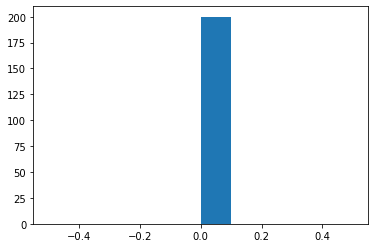

In [11]:
plt.hist(RMSEs)
plt.show()